In [1]:
import torch

In [2]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
last_hidden_states.shape

torch.Size([1, 197, 768])

In [4]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# Process Images

In [8]:
IMAGE_PATH = '/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/imagery/realsense_overhead'

In [9]:
import os

In [10]:
dishes = [IMAGE_PATH + '/' + im + '/rgb.png' for im in  os.listdir(IMAGE_PATH)]

In [11]:
len(dishes)

3493

In [12]:
dishes[0]

'/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/imagery/realsense_overhead/dish_1556572657/rgb.png'

In [40]:
from PIL import Image, ImageFilter, ImageEnhance, ImageOps

In [123]:
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 3.8 MB/s eta 0:00:003.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 6.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 887.7 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 949.1 kB/s eta 0:00:00 kB/s eta 0:00:011


In [216]:
from PIL import Image, ImageFilter, ImageEnhance
import random

def get_augmented_image(im_path):
    # Open the image
    image = Image.open(im_path)
    
    # Apply a random Gaussian blur
    blur_radius = random.uniform(1, 2)  # Adjust the range as needed
    image = image.filter(ImageFilter.GaussianBlur(blur_radius))
    
    # Randomly adjust brightness (simulate exposure variation)
    brightness_factor = random.uniform(0.4, 1.8)  # Adjust these values as needed
    image = ImageEnhance.Brightness(image).enhance(brightness_factor)
    
    # Randomly adjust contrast (simulate light variation)
    contrast_factor = random.uniform(0.7, 1.3)  # Adjust these values as needed
    image = ImageEnhance.Contrast(image).enhance(contrast_factor)
    
    # Apply a random shift (translation)
    max_shift = 20  # Maximum pixels to shift. Adjust as needed.
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    width, height = image.size
    
    # Add a black border to prevent cropping
    image = ImageOps.expand(image, border=max_shift, fill='black')  
    
    # Apply skew (shear)
    skew_x = random.uniform(-0.2, 0.2)  # Adjust the skew range as needed
    skew_y = random.uniform(-0.2, 0.2)  # Adjust the skew range as needed
    
    # Perform the affine transformation for shifting and skewing
    image = image.transform(
        (width, height),
        Image.AFFINE,
        (1, skew_x, shift_x, skew_y, 1, shift_y),
        fillcolor='black'  # Fill over-boundary areas with black
    )  # Create a horizontal line kernel
    
    # Calculate necessary zoom to eliminate black outlines
    # This is a simplistic approach; you might need to adjust the zoom factor based on your skew amounts.
    zoom_factor = 1 + max(abs(skew_x), abs(skew_y))  # Adjust based on the skew magnitude
    
    # Apply zoom
    x_size, y_size = image.size
    x_crop = int(x_size * (zoom_factor - 1) / 2)
    y_crop = int(y_size * (zoom_factor - 1) / 2)
    image = image.crop((x_crop, y_crop, x_size - x_crop, y_size - y_crop))
    image = image.resize((x_size, y_size), Image.LANCZOS)
    return image

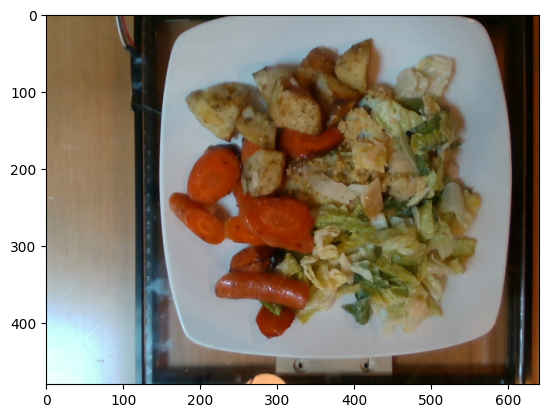

In [190]:
import matplotlib.pyplot as plt
plt.imshow(Image.open(dishes[150]))

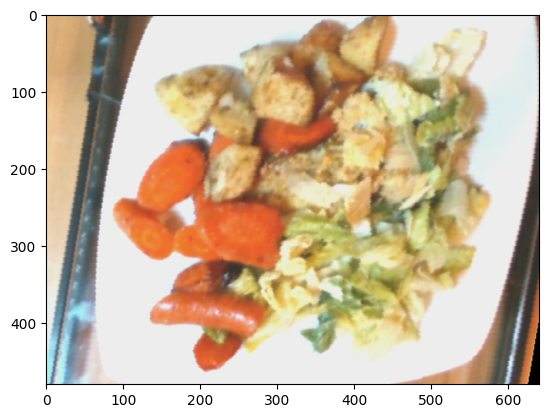

In [270]:
import matplotlib.pyplot as plt
plt.imshow(get_augmented_image(dishes[150]))

In [269]:
%%time

def get_embedding(im_path):

    dish_name = im_path.split('/')[-2]
    image = get_augmented_image(im_path)
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state[0, 0]
    return (dish_name, last_hidden_states)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [138]:
dish_name, embedding = get_embedding(dishes[0])

In [139]:
dish_name, embedding.size()

('dish_1559849537', torch.Size([768]))

# Get embeddings for data we have

In [140]:
import pandas as pd

In [141]:
data = pd.read_csv('description_with_embeddings.csv')

In [147]:
metadata = pd.read_csv('/media/technet/0B83-DFA4/nutrition5k_dataset_nosides/metadata/dish_metadata_cafe1.csv', header=None, usecols=[0, 1])
metadata.columns = ['image', 'calories']

In [142]:
data

,Unnamed: 0,image_name,description,embedding
0,0,dish_1559849537,"I'm having a simple, healthy snack with a hand...","[0.0072064949199557304, 0.03340759128332138, -..."
1,1,dish_1560443537,"Fresh fruit salad, hand-picked raspberries, bl...","[0.012388301081955433, 0.0289766788482666, -0...."
2,2,dish_1558116436,"Crispy bacon, two strips, pan-fried, simple an...","[0.027798837050795555, -0.03318409621715546, -..."
3,3,dish_1558109986,"I'm enjoying a simple meal of sliced, pan-frie...","[0.030582459643483162, -0.0088918162509799, -0..."
4,4,dish_1558637896,"A simple, healthy snack of a handful of assort...","[0.017888465896248817, -0.0057890587486326694,..."
...,...,...,...,...
719,368,dish_1557936555,"Scrambled eggs, two, microwave.","[-0.002091321162879467, -0.030263222754001617,..."
720,369,dish_1558381840,"Oatmeal, milk, banana slices, walnuts; microwa...","[-0.005124344490468502, -0.027453262358903885,..."
721,370,dish_1558546558,"Handful of almonds, raw, unsalted, about 20-25...","[-0.012985984794795513, 0.012175682000815868, ..."
722,371,dish_1560526472,"Spinach, tomatoes, olives, lettuce - a handful...","[0.023701202124357224, 0.008757668547332287, -..."


In [143]:
dishes = [IMAGE_PATH + '/' + im + '/rgb.png' for im in  data['image_name']]

In [144]:
from tqdm import tqdm

In [145]:
embedding_dicts = {}

for dish_path in tqdm(dishes):
    try:
        dish_name, embedding = get_embedding(dish_path)
        embedding_dicts[dish_name] = embedding
    except Exception as e:
        print(e)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 724/724 [03:00<00:00,  4.00it/s]


In [222]:
import pickle
with open('embeddings_augmented.pickle', 'wb') as f:
    pickle.dump(embedding_dicts, f)